In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py
import cv2
import os
import glob
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adadelta, Adam
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, History
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from __future__ import division, print_function
from collections import Counter
%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
# for fish_class in glob.glob('data/train/*'): os.mkdir('data/final_valid/' + fish_class.split('/')[2])

# rnd_ord = np.random.permutation(glob.glob('data/final_train/*/*.jpg'))
# for i in range(800): os.rename(rnd_ord[i], 'data/final_valid/' + rnd_ord[i].split('/')[2]+'/'+rnd_ord[i].split('/')[3])

In [2]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

def VGG_16(size=(224, 224), weights_path='data/vgg16_bn_conv.txt'):
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,)+size))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))


    if weights_path:
        model.load_weights(weights_path)

    return model


In [5]:
size = (360, 270)
model = VGG_16(size=size)


for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(4))

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 360, 270)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [6]:


# nb_train_samples = len(glob.glob('data/train/*/*.jpg'))+len(glob.glob('data/train/*/*/*.jpg'))
# nb_validation_samples = len(glob.glob('valid/data/train/*/*.jpg'))+len(glob.glob('valid/data/train/*/*/*.jpg'))

nb_train_samples = len(glob.glob('data/order/*/*.jpg'))+len(glob.glob('data/order/*/*/*.jpg'))
nb_validation_samples = len(glob.glob('data/order/*/*.jpg'))+len(glob.glob('data/order/*/*/*.jpg'))

nb_epoch = 8
bath_size = 16
nb_test_samples = 1000
lr=0.001


classes=[]
for i in range(0,16):
    classes.append(str(i+1))
# classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
# classes = ['NoF', 'FISH']

# train_datagen = ImageDataGenerator(
#         shear_range=0.2,
#         zoom_range=0.1,
#         rotation_range=10.,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         horizontal_flip=True)

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
#         'data/train/',
        'data/order/',
        target_size=size,
        batch_size=bath_size,
        shuffle = True,
        classes=classes,
        class_mode='categorical')

valid_datagen = ImageDataGenerator()

validation_generator = valid_datagen.flow_from_directory(
#         'valid/data/train/',
        'data/order/',
        target_size=size,
        batch_size=bath_size,
        shuffle = True,
        classes=classes,
        class_mode='categorical')

callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), \
              metrics=["accuracy"])

# fine-tune the model
hist = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples,
        callbacks=callbacks)



Found 1518 images belonging to 16 classes.
Found 1518 images belonging to 16 classes.
Epoch 1/8
1518/1518 [==============================] - 90s - loss: 0.1597 - acc: 0.9572 - val_loss: 0.0046 - val_acc: 0.9993

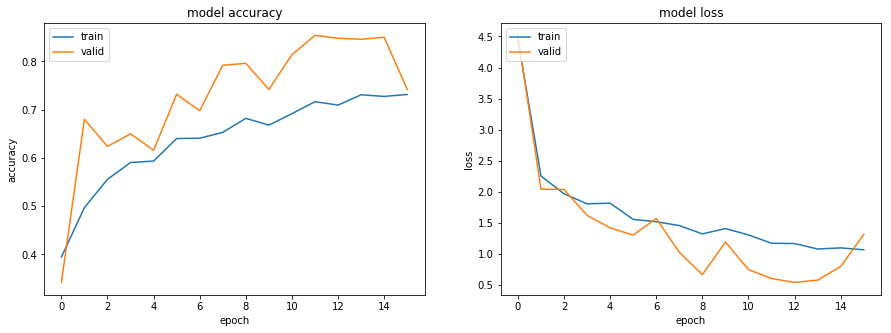

In [5]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [13]:
# model.save_weights('vgg16_aug_lessdrop1.pkl')
model.save_weights('vgg16_group_order.pkl')

In [7]:
# nb_train_samples = len(glob.glob('data/train/*/*.jpg'))
# nb_validation_samples = len(glob.glob('valid/data/train/*/*.jpg'))
# nb_epoch = 50
# bath_size = 16
# nb_test_samples = 1000

# classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

# train_datagen = ImageDataGenerator(
#         shear_range=0.2,
#         zoom_range=0.1,
#         rotation_range=10.,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         horizontal_flip=True)

# train_generator = train_datagen.flow_from_directory(
#         'data/train/',
#         target_size=size,
#         batch_size=bath_size,
#         shuffle = True,
#         classes=classes,
#         class_mode='categorical')

valid_datagen = ImageDataGenerator()

validation_generator = valid_datagen.flow_from_directory(
        'valid/data/train/',
        target_size=size,
        batch_size=bath_size,
        shuffle = False,
        classes=classes,
        class_mode='categorical')

# callbacks = [EarlyStopping(monitor='val_loss', patience=1, verbose=0)]
# model.compile(loss='categorical_crossentropy', optimizer="adadelta", \
#               metrics=["accuracy"])


Found 500 images belonging to 8 classes.


In [8]:
a=model.predict_generator(validation_generator,500)

In [9]:

np.savetxt('testres.csv',a.round(decimals=2),fmt='%g,')

In [10]:
test_aug = 5
test_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

for aug in range(test_aug):
    print('Predictions for Augmented -', aug)
    random_seed = np.random.random_integers(0, 100000)

    test_generator = test_datagen.flow_from_directory(
            'data/test/',
            target_size=size,
            batch_size=bath_size,
            shuffle = False,
            seed = random_seed,
            classes = None,
            class_mode = None)

    test_image_list = test_generator.filenames
    if aug == 0:
        predictions = model.predict_generator(test_generator, nb_test_samples)
    else:
        predictions += model.predict_generator(test_generator, nb_test_samples)

predictions /= test_aug


Predictions for Augmented - 0
Found 1000 images belonging to 1 classes.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 100000 + 1) instead


Predictions for Augmented - 1
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 2
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 3
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 4
Found 1000 images belonging to 1 classes.


In [1]:
# clip predictions
c = 0
preds = np.clip(predictions, c, 1-c)

print('Begin to write submission file ..')
f_submit = open('submit_2.csv', 'w')
f_submit.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
for i, image_name in enumerate(test_generator.filenames):
    pred = ['%.6f' % p for p in preds[i, :]]
    if i%100 == 0:
        print(i, '/', 1000)
    f_submit.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))

f_submit.close()

NameError: name 'np' is not defined